# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [255]:
# !pip install pycrf
# !pip install sklearn-crfsuite

In [256]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

In [257]:
import pandas as pd
import numpy as np
from IPython.display import display


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


In [258]:
def load_n_preprocess(file_name):
    opened = open(file_name, 'r')
    loaded = opened.readlines()
    opened.close()
    
    all_sentence = []
    sentence = ""

    for word in loaded:
        word = word.strip() # removing any space
        if word == "":
            all_sentence.append(sentence) # To append the final sentence list
#             print(sentence)
#             print("***********")
            sentence = ""
        else:
            if sentence:
                sentence = sentence + " " + word
            else:
                sentence = word
                
    return all_sentence

### Construct the proper sentences from individual words and print the 5 sentences.

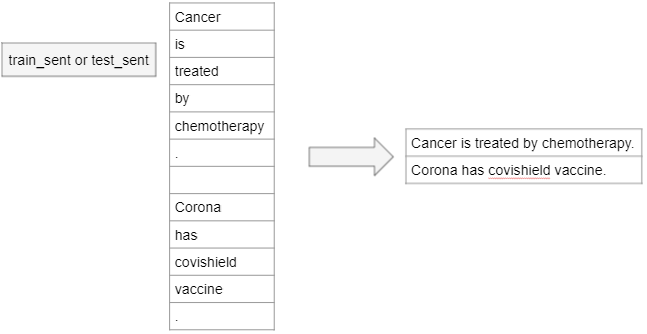

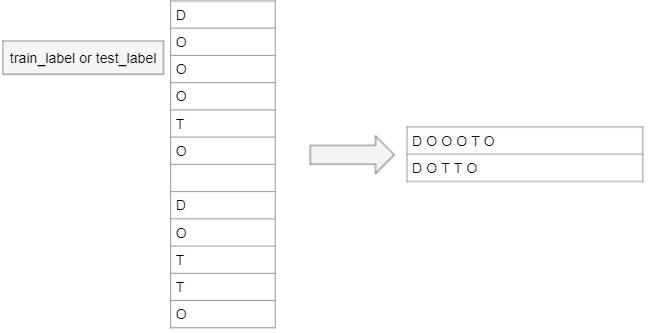

In [259]:
train_sent = load_n_preprocess('train_sent')
train_label = load_n_preprocess('train_label')
test_sent = load_n_preprocess('test_sent')
test_label = load_n_preprocess('test_label')

In [260]:
def print_sent(sents, label, count=5):
    for i in range(count):
        print("Sentence", i, " : ", sents[i])
        
        display(pd.DataFrame([sents[i].split(), label[i].split()], columns = np.arange(len(sents[i].split())), index = ["sentences", "label"]))
        
#         print("Label", i, " : ", label[i])
#         print( "###################"*5, "\n")

#     https://stackoverflow.com/questions/51288869/print-visually-pleasing-dataframes-in-for-loop-in-jupyter-notebook-pandas

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt


In [352]:
opened = open("train_label", 'r')
loaded = opened.readlines()
opened.close()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


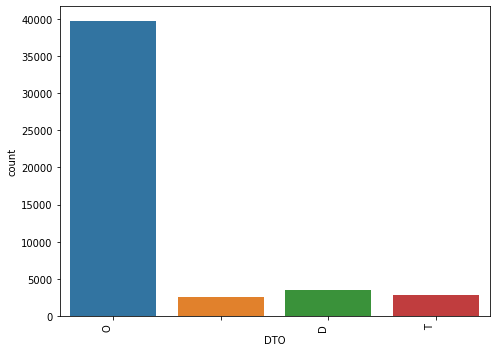

In [353]:
#Words distribution across DTO in train label
plt.figure(figsize=(7, 5))
ax = sns.countplot('DTO', data=pd.DataFrame(loaded, columns=["DTO"]), orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [354]:
opened = open("test_label", 'r')
loaded = opened.readlines()
opened.close()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


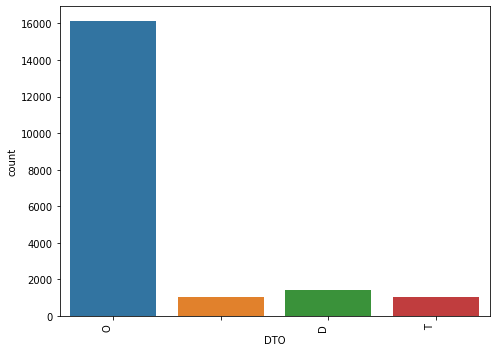

In [355]:
#Words distribution across DTO in test label
plt.figure(figsize=(7, 5))
ax = sns.countplot('DTO', data=pd.DataFrame(loaded, columns=["DTO"]), orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

### Printing first 5 TRAIN sentence and it's labels

In [261]:
print_sent(train_sent, train_label, count=5)

Sentence 0  :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


0     1       2  3   4  5   6      7   8    9   ... 35   36  \
sentences  All  live  births  >  or  =  23  weeks  at  the  ...  ,  and   
label        O     O       O  O   O  O   O      O   O    O  ...  O    O   

                 37     38 39  40       41    42      43 44  
sentences  practice  group  (  to  reflect  risk  status  )  
label             O      O  O   O        O     O       O  O  

[2 rows x 45 columns]

Sentence 1  :  The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


0      1         2     3    4     5  6  7    8   9   ...       15  \
sentences  The  total  cesarean  rate  was  14.4  %  (  344  of  ...  primary   
label        O      O         O     O    O     O  O  O    O   O  ...        O   

             16   17    18 19 20   21  22    23 24  
sentences  rate  was  11.4  %  (  244  of  2144  )  
label         O    O     O  O  O    O   O     O  O  

[2 rows x 25 columns]

Sentence 2  :  Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


0             1    2    3     4       5           6  7   \
sentences  Abnormal  presentation  was  the  most  common  indication  (   
label             O             O    O    O     O       O           O  O   

             8  9  10  11  12   13 14  
sentences  25.6  %  ,  88  of  344  )  
label         O  O  O   O   O    O  O

Sentence 3  :  The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


0   1          2   3         4     5  6               7   \
sentences  The  ``  corrected  ''  cesarean  rate  (  maternal-fetal   
label        O   O          O   O         O     O  O               O   

                 8    9   ...       28    29   30   31 32 33   34  35    36 37  
sentences  medicine  and  ...  primary  rate  was  9.6  %  (  190  of  1975  )  
label             O    O  ...        O     O    O    O  O  O    O   O     O  O  

[2 rows x 38 columns]

Sentence 4  :  Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


0   1         2    3    4     5       6           7   8     9   \
sentences  Arrest  of  dilation  was  the  most  common  indication  in  both   
label           O   O         O    O    O     O       O           O   O     O   

           ...  12         13 14    15   16    17 18 19            20 21  
sentences  ...  ''  subgroups  (  23.4  and  24.6  %  ,  respectively  )  
label      ...   O          O  O     O    O     O  O  O             O  O  

[2 rows x 22 columns]

### Printing first 5 TEST sentence and it's labels

In [262]:
print_sent(test_sent, test_label, count=5)

Sentence 0  :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


0  1     2    3           4     5         6  7   \
sentences  Furthermore  ,  when  all  deliveries  were  analyzed  ,   
label                O  O     O    O           O     O         O  O   

                   8   9   ...    34 35       36   37 38 39   40  41    42 43  
sentences  regardless  of  ...  2214  ;  primary  9.2  %  ,  183  of  1994  )  
label               O   O  ...     O  O        O    O  O  O    O   O     O  O  

[2 rows x 44 columns]

Sentence 1  :  As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


0    1        2            3          4  5      6   7   8   \
sentences  As  the  ambient  temperature  increases  ,  there  is  an   
label       O    O        O            O          O  O      O   O   O   

                 9   10          11     12    13   14   15         16   17  \
sentences  increase  in  insensible  fluid  loss  and  the  potential  for   
label             O   O           O      O     O    O    O          O    O   

                    18  
sentences  dehydration  
label                O

Sentence 2  :  The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


0      1     2            3       4     5   6   7    8        9   \
sentences  The  daily  high  temperature  ranged  from  71  to  104  degrees   
label        O      O     O            O       O     O   O   O    O        O   

           ...      14    15   16  17    18  19      20   21     22      23  
sentences  ...  ranged  from  1.7  to  24.7  cm  during  the  study  period  
label      ...       O     O    O   O     O   O       O    O      O       O  

[2 rows x 24 columns]

Sentence 3  :  There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


0    1  2            3            4        5    6   7  8   9   \
sentences  There  was  a  significant  correlation  between  the  2-  ,  3-   
label          O    O  O            O            O        O    O   O  O   O   

           ... 28    29 30 31 32 33  34 35     36 37  
sentences  ...  =  0.31  ,  p  &  #  60  ;  0.001  )  
label      ...  O     O  O  O  O  O   O  O      O  O  

[2 rows x 38 columns]

Sentence 4  :  Fluctuations in ambient temperature are inversely correlated to changes in AFI


0   1        2            3    4          5           6   \
sentences  Fluctuations  in  ambient  temperature  are  inversely  correlated   
label                 O   O        O            O    O          O           O   

           7        8   9    10  
sentences  to  changes  in  AFI  
label       O        O   O    O

### Count the number of sentences in the processed train and test dataset 

In [263]:
print("No. sentences in processed train dataset is: ", len(train_sent))
print("No. sentences in processed test dataset is: ", len(test_sent))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [264]:
print("No. sentences in processed train dataset is: ", len(train_label))
print("No. sentences in processed test dataset is: ", len(test_label))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

Extracting NOUN or PROPN using tokens

In [265]:
all_noun_propn = []
all_sentence = train_sent + test_sent

for sentence in all_sentence:
    doc = model(sentence)
    
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            all_noun_propn.append(token.text)

In [266]:
len(all_noun_propn)

24327

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [267]:
from nltk import FreqDist

In [268]:
word_frequency = FreqDist(all_noun_propn)

In [269]:
pd.DataFrame(word_frequency.most_common(25), columns=["Sentence", "Count"])

Sentence  Count
0       patients    491
1      treatment    281
2              %    247
3         cancer    200
4        therapy    175
5          study    153
6        disease    141
7           cell    140
8           lung    116
9          group     94
10  chemotherapy     88
11          gene     87
12       effects     85
13       results     79
14         women     77
15           use     75
16          risk     71
17         cases     71
18       surgery     71
19      analysis     70
20          rate     67
21      response     66
22      survival     65
23      children     64
24        effect     63

## Model1: 
#### Using the same code from CRF.ipynb (Custom NER: Python Implementation Part-I)


## Defining features for CRF
*******
list of features used:
- f1 = serves as word id
- f2 = last three characters
- f3 = last two characters
- f4 = is the word in all uppercase
- f5 = is the word a number
- f6 = is the word starting with a capital lettes

extra feature:
if pos>0:
- fx1 = prev_word to lower
- fx2 = prev_word is upper
- fx3 = prev_word is digits
- fx4 = prev_word starts with capital letter

else:
- fx1 = BEG(beginning of text)

if pos reached end:
- fx1 = ENd(ending of text)

In [270]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

### Write a code/function to get the features for a sentence

In [272]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Visualizing the input features

In [273]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [274]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [275]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [276]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [277]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

## Build the CRF Model

In [278]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [279]:
repr(crf)

/root/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


'CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,\n    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,\n    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,\n    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,\n    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,\n    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,\n    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)'

### Tranning model

In [280]:
crf.fit(X_train, y_train)

/root/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [281]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [282]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9041392758864858


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

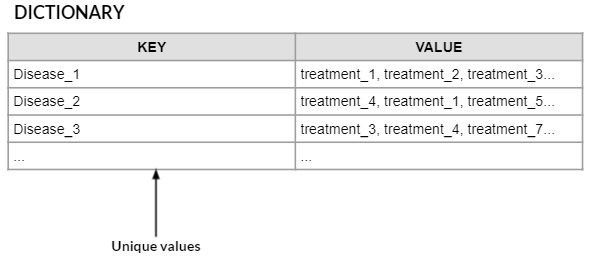

## Creating Dataframe for Disease	and Treatments

In [283]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

Empty DataFrame
Columns: [Disease, Treatments]
Index: []

In [284]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Disease  \
0                            hereditary retinoblastoma   
1    unstable angina or non-Q-wave myocardial infar...   
2                              coronary-artery disease   
3               primary pulmonary hypertension ( PPH )   
4                                           cellulitis   
..                                                 ...   
98                 temporomandibular joint arthropathy   
99                        severe secondary peritonitis   
100          hepatic metastases from colorectal cancer   
101                           Poliomyelitis prevention   
102                              chronic renal failure   

                                            Treatments  
0                                         radiotherapy  
1                                        roxithromycin  
2                           Antichlamydial antibiotics  
3                                        fenfluramines  
4       G-CSF therapy intravenous antibiotic treatment  
..                                                 ...  
98                              arthroscopic treatment  
99                                 Surgical management  
100  Hepatic arterial infusion of chemotherapy afte...  
101                      live oral poliovirus vaccines  
102                                            Epoetin  

[103 rows x 2 columns]

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [285]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

Disease    Treatments
0  hereditary retinoblastoma  radiotherapy

## Model2: Adding POS tag in feature

In [286]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos] # adding POS tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # adding POS tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [287]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [288]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ']

In [289]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'BEG']

In [290]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [291]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [292]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [293]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [295]:
crf.fit(X_train, y_train)

/root/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [296]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [297]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9059522687350653


## Creating Dataframe for Disease	and Treatments

In [298]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

Empty DataFrame
Columns: [Disease, Treatments]
Index: []

In [299]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Disease  \
0                            hereditary retinoblastoma   
1                            had myocardial infarction   
2    unstable angina or non-Q-wave myocardial infar...   
3                           early Parkinson 's disease   
4                               abdominal tuberculosis   
..                                                 ...   
99                        severe secondary peritonitis   
100          hepatic metastases from colorectal cancer   
101                              chronic renal failure   
102                          epithelial ovarian cancer   
103                        responsive multiple myeloma   

                                            Treatments  
0                                         radiotherapy  
1    mg aspirin , 3 mg warfarin with 80 mg aspirin ...  
2                                        roxithromycin  
3                               Ropinirole monotherapy  
4                                             steroids  
..                                                 ...  
99                                 Surgical management  
100  Hepatic arterial infusion of chemotherapy afte...  
101                                            Epoetin  
102                             High-dose chemotherapy  
103  `` Tandem '' high-dose chemoradiotherapy with ...  

[104 rows x 2 columns]

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [300]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

Disease    Treatments
0  hereditary retinoblastoma  radiotherapy

### we can see some improvement in accuracy from 90.413 to 90.595

- lets try adding Depency tag and see result

## Model3: Adding POS tag and Dependancy tag in feature

In [301]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [302]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [303]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [304]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [305]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [306]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [307]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [308]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [310]:
crf.fit(X_train, y_train)

/root/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [311]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [312]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9069313546313461


## Creating Dataframe for Disease	and Treatments

In [313]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

Empty DataFrame
Columns: [Disease, Treatments]
Index: []

In [314]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Disease  \
0                            hereditary retinoblastoma   
1                            had myocardial infarction   
2    unstable angina or non-Q-wave myocardial infar...   
3                              coronary-artery disease   
4               primary pulmonary hypertension ( PPH )   
..                                                 ...   
102                temporomandibular joint arthropathy   
103                       severe secondary peritonitis   
104          hepatic metastases from colorectal cancer   
105                              chronic renal failure   
106                          epithelial ovarian cancer   

                                            Treatments  
0                                         radiotherapy  
1        aspirin , or 1 mg warfarin with 80 mg aspirin  
2                                        roxithromycin  
3                           Antichlamydial antibiotics  
4                                        fenfluramines  
..                                                 ...  
102                             arthroscopic treatment  
103                                Surgical management  
104  Hepatic arterial infusion of chemotherapy afte...  
105                                            Epoetin  
106                             High-dose chemotherapy  

[107 rows x 2 columns]

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [315]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

Disease    Treatments
0  hereditary retinoblastoma  radiotherapy

### we can see some improvement in accuracy from 90.595 to 90.693

- lets try increasing max_iterations to 500

## Model 4: max_iterations to 500

In [316]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [317]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [318]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [319]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [320]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [321]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [322]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [330]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [331]:
crf.fit(X_train, y_train)

/root/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=500,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [332]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [333]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9119586377606935


## Creating Dataframe for Disease	and Treatments

In [334]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

Empty DataFrame
Columns: [Disease, Treatments]
Index: []

In [335]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Disease  \
0                            nonimmune hydrops fetalis   
1                            hereditary retinoblastoma   
2    unstable angina or non-Q-wave myocardial infar...   
3                              coronary-artery disease   
4               primary pulmonary hypertension ( PPH )   
..                                                 ...   
105                temporomandibular joint arthropathy   
106                       severe secondary peritonitis   
107          hepatic metastases from colorectal cancer   
108                          epithelial ovarian cancer   
109                        responsive multiple myeloma   

                                            Treatments  
0                                              Trisomy  
1                                         radiotherapy  
2                                        roxithromycin  
3                           Antichlamydial antibiotics  
4                                        fenfluramines  
..                                                 ...  
105                             arthroscopic treatment  
106                                Surgical management  
107  Hepatic arterial infusion of chemotherapy afte...  
108                             High-dose chemotherapy  
109  `` Tandem '' high-dose chemoradiotherapy with ...  

[110 rows x 2 columns]

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [336]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

Disease    Treatments
1  hereditary retinoblastoma  radiotherapy

## We can see some improvement in accuracy from 90.693 to 91.195
- And we can see there is an increase in the number of record of disease and treatement from 108 to 111.


# Here we can still see the the treatment for the disease name: 'hereditary retinoblastoma' is radiotherapy.